# Deep Q-Learning


We can solve Grid World, that's awesome: we have agents that learn! So let's have them learn how to
play Atari video games, such as pong!

But... Grid World has a state space of ~20... Atari games have a state space of ~$10^{17000}$ using
pixels (consider that there are ~$10^{82}$ atoms in the observable universe). Tabular methods don't
scale to such large spaces.

To overcome this limitation, we will use function approximation and approximate the Q function using
neural networks!

**Prerequisites**: Neural Network fundamentals as well as PyTorch basic APIs.


## Gymnasium and Atari Pong

[Gymnasium](https://gymnasium.farama.org/index.html) is an API standard for reinforcement learning,
with a vast collections of environments. Let's use it!


In [2]:
import random
import tempfile

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import ale_py
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, RecordVideo

from util.gymnastics import DEVICE, init_random, plot_scores, show_gym_video_recording

In [ ]:
# Let's learn Gymnasium! https://ale.farama.org/environments/pong/
def gym_simulate(agent=None):
    """Runs an Atari pong game with our agent passed as input."""
    sim_env = gym.make("PongDeterministic-v4", render_mode="rgb_array_list", frameskip=1)
    sim_env = init_random(sim_env)
    sim_env = AtariPreprocessing(sim_env)
    sim_env = RecordVideo(sim_env, tempfile.tempdir, lambda i: i == 0)

    init_position, _ = sim_env.reset()
    first_observation, _, _, _, _ = sim_env.step(1)  # starts the game :)
    state = np.stack([init_position, first_observation])

    for _ in range(2_500):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        observation, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            observation, _ = sim_env.reset()
        state = np.stack([state[1], observation])

    sim_env.close()
    return show_gym_video_recording()

A.L.E: Arcade Learning Environment (version 0.9.1+aff5939)
[Powered by Stella]


MoviePy - Building file /tmp/rl-video.gif with imageio.


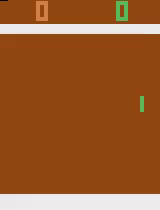

In [3]:
gym_simulate()

## DQN

### Q Function Approximation via Neural Network

Instead of a "lookup" table, $Q$ is going to be a parameterized functions: $Q_\theta(s,a)$. The set
of parameters $\theta$ corresponds to the parameters (e.g., weights) of the neural network trained
to approximate $Q$.

We cannot use the TD error $\delta^{TD}$ to update $Q$ anymore, because we now have to optimize the
set of parameters $\theta$ instead. The target is still the following:

$$
target(s') = R(s, a, s') + \gamma \max_{a'} Q_{\theta_{k}}(s', a')
$$

But now we use gradient descent to update the parameters $\theta$ (in a sense still minimizing
$\delta^{TD}$):

$$
\theta_{k+1} = \theta_k - \alpha \nabla_\theta
   \biggl\{ \frac{1}{2} \Bigl[ Q_\theta(s,a) - target(s') \Bigr] ^ 2 \biggr\}
$$

Luckily, we don't have to implement any neural networks or know automatic differentiation math
ourselves thanks to modern frameworks like PyTorch, TensorFlow, JAX! We use PyTorch in this course.


In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2)  # 2x84x84 to 4x40x40
        self.conv2 = nn.Conv2d(4, 16, kernel_size=8, stride=4)  # 4x40x40 to 16x9x9
        self.lsize = 16 * 9 * 9
        self.fc1 = nn.Linear(self.lsize, 256)
        self.fc2 = nn.Linear(256, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, self.lsize)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Test for neural network!
init_random()

test_net = QNetwork(action_size=6)

fake_img = np.random.randn(2, 84, 84)
fake_tensor = torch.from_numpy(fake_img).float()
result = test_net.forward(fake_tensor).detach()

expected_result = torch.tensor([[-0.0739, 0.0363, -0.0076, -0.0517, 0.0065, -0.0569]])
assert torch.allclose(result, expected_result, atol=0.0001)

### Algorithm

The algorith from the [2013 paper](https://arxiv.org/abs/1312.5602) is approximately the following:

<div style="width: 50%">
  <img src="../assets/03_DQN_algo_highlighted.png">
  <br>
  <small></small>
</div>

Two techniques to highlight:

- **Replay Buffer:** Helpful for data efficiency (data reused for many updates). Also, learning from
  consecutive samples is inefficient because of the strong correlations. Using a replay buffer and
  randomizing the samples breaks such correlations reducing variance of the updates. It helps
  preventing _catastrophic forgetting_.
- **Target Network:** We don't update the same network at every step, because the target would
  effectively become non-stationary (e.g., dog chasing its own tail) and learning become unstable.
  Instead, we keep the "target" stable for a while, and then (every _C_ steps) we update it to the
  current parameters.

We can see how the _blue_ box is mostly equivalent to Q Learning, but the _red_ part of the learning
algorithm runs gradient descent on the Q network parameters.


### Replay Buffer


In [ ]:
from collections import deque
from typing import NamedTuple


class Experience(NamedTuple):
    """An Experience stored in the replay buffer."""

    state: np.array
    action: np.array
    reward: float
    next_state: np.array
    done: bool


class ReplayBuffer:
    """The replay buffer for DQN."""

    def __init__(self, buffer_size=int(1e4)):
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        stored_action = np.atleast_1d(action)
        e = Experience(state, stored_action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 32):
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions = torch.from_numpy(np.stack(actions)).long().to(DEVICE)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Replay buffer minimal test.
test_buffer = ReplayBuffer()


def fake_state():
    return np.random.rand(4, 5)


test_buffer.add(fake_state(), [10], 1.0, fake_state(), False)
test_buffer.add(fake_state(), [11], 2.0, fake_state(), False)
test_buffer.add(fake_state(), 12, 3.0, fake_state(), False)
test_buffer.add(fake_state(), 13, 4.0, fake_state(), False)
test_buffer.add(fake_state(), [14], 5.0, fake_state(), True)

batch_size = 3
state_shape = (batch_size, 4, 5)

t_states, t_actions, t_rewards, t_next_states, t_dones = test_buffer.sample(batch_size)

assert t_states.shape == state_shape
assert t_actions.shape == (batch_size, 1)
assert t_rewards.shape == (batch_size, 1)
assert t_next_states.shape == state_shape
assert t_dones.shape == (batch_size, 1)

### Training Loop


In [ ]:
def start_episode(env: gym.Env):
    """Method to call to start a new episode for pong in DQN training."""
    state, _ = env.reset()
    obs, _, _, _, _ = env.step(1)  # Starts the game :)
    return np.stack([state, obs])

In [ ]:
from util.gymnastics import epsilon_gen


def train(env, agent, max_timesteps=int(1e6)) -> list[int]:
    scores = []
    score = 0.0
    n_episode = 1
    eps_gen = epsilon_gen(eps_start=0.1, eps_decay=0.995, eps_min=0.01)
    epsilon = next(eps_gen)
    state = start_episode(env)

    for t in range(max_timesteps):
        action = agent.act(state, epsilon)
        observation, reward, terminated, truncated, _ = env.step(action)
        next_state = np.stack([state[1], observation])
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            scores.append(score)
            avg = np.mean(scores[-25:])
            print(
                f"\rEpisode {n_episode}\tScore: {score:.2f}\tT={t:6} (avg={avg:.2f})",
                end="\n" if n_episode % 25 == 0 else "",
            )
            score = 0.0
            n_episode += 1
            epsilon = next(eps_gen)
            state = start_episode(env)

    agent.checkpoint()
    np.savetxt("dqn_scores.csv", np.asarray(scores, dtype=np.int16), delimiter=",")
    return scores

### Agent Code


In [ ]:
class Agent:
    """Agent that interacts with and learns from the environment."""

    def __init__(
        self,
        action_size=6,
        gamma: float = 0.99,
        tau: float = 1e-3,
        lr: float = 1e-4,
        batch_size: int = 32,
        learn_every: int = 4,
        update_target_every: int = 2,
        preload_file: str = None,
    ):
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.batch_size = batch_size
        self.learn_every = learn_every
        self.update_target_every = update_target_every
        self.t_learn_step = 0
        self.t_update_target_step = 0

        self.memory = ReplayBuffer()
        self.qnetwork_local = QNetwork(action_size).to(DEVICE)
        self.qnetwork_target = QNetwork(action_size).to(DEVICE)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.qnetwork_target.eval()
        self.optimizer = optim.RMSprop(self.qnetwork_local.parameters(), lr=self.lr)

        if preload_file is not None:
            print(f"Loading pre-trained model: {preload_file}")
            self.qnetwork_local.load_state_dict(torch.load(preload_file, map_location=DEVICE))

    def step(self, state, action, reward, next_state, done):
        """Tells the agent to make a step: record experience and possibly learn."""
        self.memory.add(state, [action], reward, next_state, done)
        self.t_learn_step = (self.t_learn_step + 1) % self.learn_every
        if self.t_learn_step == 0:
            if len(self.memory) > self.batch_size:
                self.learn()
        self.t_update_target_step = (self.t_update_target_step + 1) % self.update_target_every
        if self.t_update_target_step == 0:
            Agent.soft_update_model_params(self.qnetwork_local, self.qnetwork_target, self.tau)

    def act(self, state: np.array, eps=0.0):
        """Makes the agent take an action for the state passed as input."""
        state = torch.from_numpy(state).float().to(DEVICE)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self):
        """Executes one learning step for the agent."""
        experiences = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            target_action_values = self.qnetwork_target(next_states).detach()  # (batch_s, action_s)
            max_action_values = target_action_values.amax(1, keepdim=True)  # (batch_size, 1)
            Q_targets = rewards + (self.gamma * max_action_values * (1 - dones))  # (batch_size, 1)

        predictions = self.qnetwork_local(states)
        Q_expected = predictions.gather(1, actions)
        loss = F.huber_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    @staticmethod
    def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
        """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
        for dest_param, src_param in zip(dest.parameters(), src.parameters()):
            dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

    def checkpoint(self):
        """Save the QNetwork weights in a file."""
        torch.save(self.qnetwork_local.state_dict(), "dqn_weights.pth")

### Run Training and Simulation!


In [ ]:
def pretrained_simulation():
    pretrained_agent = Agent(preload_file="solution/dqn_weights_pre.pth")
    pretrained_scores = np.loadtxt(f"solution/dqn_scores_pre.csv", delimiter=",").astype(np.int16)
    plot_scores(pretrained_scores)
    return gym_simulate(pretrained_agent)


# Uncomment the line below to watch the pretrained agent :)
# pretrained_simulation()

Episode 25	Score: -19.00	T= 21584 (avg=-20.60)
Episode 50	Score: -21.00	T= 43312 (avg=-20.68)
Episode 75	Score: -21.00	T= 67630 (avg=-20.20)
Episode 100	Score: -19.00	T= 94065 (avg=-19.24)
Episode 125	Score: -20.00	T=124631 (avg=-18.60)
Episode 150	Score: -18.00	T=159059 (avg=-18.04)
Episode 175	Score: -11.00	T=200732 (avg=-15.72)
Episode 200	Score: -13.00	T=247113 (avg=-15.84)
Episode 225	Score: -13.00	T=294397 (avg=-15.16)
Episode 250	Score: -18.00	T=347187 (avg=-12.36)
Episode 275	Score: -1.00	T=404138 (avg=-12.32))
Episode 300	Score: -21.00	T=467403 (avg=-10.08)
Episode 325	Score: -8.00	T=534675 (avg=-6.56)))
Episode 350	Score: 5.00	T=607263 (avg=3.80))4)
Episode 375	Score: -3.00	T=679665 (avg=6.16)
Episode 400	Score: 19.00	T=747793 (avg=11.00)
Episode 425	Score: 3.00	T=824993 (avg=6.12)))
Episode 450	Score: 17.00	T=885438 (avg=13.04)
Episode 475	Score: 19.00	T=932422 (avg=17.68)
Episode 500	Score: 18.00	T=977733 (avg=18.48)
Episode 511	Score: 20.00	T=998506 (avg=17.76)

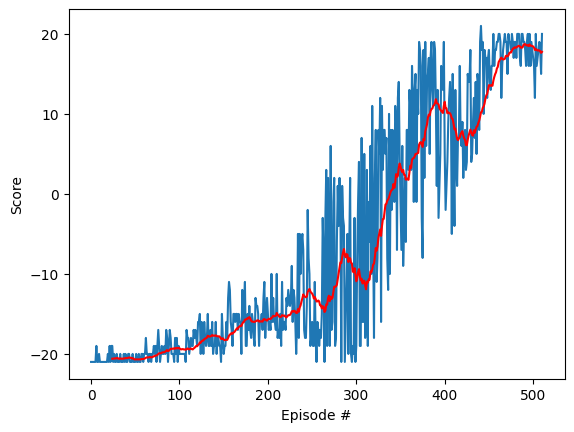

In [12]:
with gym.make("PongDeterministic-v4", frameskip=1) as env:
    env = init_random(env)
    env = AtariPreprocessing(env)
    agent = Agent(action_size=env.action_space.n)
    scores = train(env, agent)

plot_scores(scores)

MoviePy - Building file /tmp/rl-video.gif with imageio.


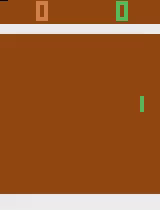

: 

In [ ]:
gym_simulate(agent)

## Where To Go From Here

- Some tricks: e.g., acting only every other step and collect two steps help speeding up and
  stabilizing the training.
- Improvements: prioritized experience reply, double DQN, up to Rainbow.
- Check out official implementations such as Stable Baselines.
